## Totally depriciated, DO NOT WASTE YOUR TIME

In [1]:
import init_paths
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.cio as cio
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as at
import glob
import matplotlib.pyplot as plt
# from cortico_cereb_connectivity.scripts.script_train_eval_models import *
from collections import defaultdict
import cortico_cereb_connectivity.evaluation as ev
import matplotlib.pyplot as plt
from scipy import stats
import SUITPy as suit

In [2]:
def plot_cereb_data(data,cereb_atlas,cscale=[-0.1,0.1]):
    # Transform the data to a nifti image
    nifti_img = cereb_atlas.data_to_nifti(data)
    # Map to the cerebellar flatmap 
    flat_data = suit.flatmap.vol_to_surf(nifti_img)
    # Plot 
    suit.flatmap.plot(flat_data,new_figure=False,cscale=cscale)

In [3]:
def loop_subject(config, fitted_model, train_info, sel_sub):
    eval_voxels = defaultdict(list)
    for i, sub in enumerate(config["subj_list"]):
        if sub in sel_sub:
            print(f'- Evaluate {sub}')

            YY, info, _ = fdata.get_dataset(gl.base_dir,
                                        config["eval_dataset"],
                                        atlas=config["cerebellum"],
                                        sess=config["eval_ses"],
                                        type=config["type"],
                                        subj=str(sub))
            XX, info, _ = fdata.get_dataset(gl.base_dir,
                                        config["eval_dataset"],
                                        atlas=config["cortex"],
                                        sess=config["eval_ses"],
                                        type=config["type"],
                                        subj=str(sub))
            # Average the cortical data over parcels
            X_atlas, _ = at.get_atlas(config['cortex'],gl.atlas_dir)
            # get the vector containing tessel labels
            X_atlas.get_parcel(config['label_img'], unite_struct = False)
            # get the mean across tessels for cortical data
            XX, labels = fdata.agg_parcels(XX, X_atlas.label_vector,fcn=np.nanmean)

            # Remove Nans
            Y = np.nan_to_num(YY[0,:,:])
            X = np.nan_to_num(XX[0,:,:])

            # Add explicit rest to sessions 
            if config["add_rest"]:
                Y,_ = rm.add_rest(Y,info)
                X,info = rm.add_rest(X,info)

            #Definitely subtract intercept across all conditions
            X = (X - X.mean(axis=0))
            Y = (Y - Y.mean(axis=0))

            if 'std_cortex' in config.keys():
                X = rm.std_data(X,config['std_cortex'])
            if 'std_cerebellum' in config.keys():
                Y = rm.std_data(Y,config['std_cerebellum'])

            # cross the halves within each session
            if config["crossed"] is not None:
                Y = rm.cross_data(Y,info,config["crossed"])

            # eval only on some runs?
            if config["eval_run"]!='all':
                if isinstance(config["eval_run"], list):
                    run_mask = info['run'].isin(config["eval_run"])
                    Y = Y[run_mask.values, :]
                    X = X[run_mask.values, :]
                    info = info[run_mask]

            # Loop over models
            for j, (fm, tinfo) in enumerate(zip(fitted_model, train_info)):
                
                # Use subject-specific model? (indiv or loo or mix)
                if (isinstance(fm,list)):
                    fitM = fm[i]
                else:
                    fitM = fm

                if (isinstance(tinfo,list)):
                    ti = tinfo[i]
                else:
                    ti = tinfo

                # Get model predictions
                Y_pred = fitM.predict(X)
                return Y_pred, Y

In [4]:
save_path = os.path.abspath('/home/ROBARTS/ashahb7/Github/bayes_temp')

In [ ]:
config = rm.get_eval_config(model='bayes', cerebellum='MNISymC3')
dataset = fdata.get_dataset_class(gl.base_dir, dataset="MDTB")
config["subj_list"] = dataset.get_participants().participant_id

ext_list = [8]
dirname=[]
mname=[]
for a in ext_list:
    dirname.append(f"MDTB_CondHalf_ses-s1_run-all_Icosahedron1002_L2reg")
    mname.append(f"MDTB_CondHalf_ses-s1_run-all_Icosahedron1002_L2reg_A{a}")

fitted_model_bayes,train_info_bayes = rm.get_fitted_models(dirname,mname,config)
# save models for later optimization
for s, conn_model in enumerate(fitted_model_bayes[0]):
    print(save_path + "/"+config["model"]+"_sub" + str(s))
    cio.save_model(conn_model,train_info_bayes[0], save_path + "/"+config["model"]+"_sub" + str(s))

In [ ]:
config = rm.get_eval_config(model='loo', cerebellum='MNISymC3')
dataset = fdata.get_dataset_class(gl.base_dir, dataset="MDTB")
config["subj_list"] = dataset.get_participants().participant_id

ext_list = [8]
dirname=[]
mname=[]
for a in ext_list:
    dirname.append(f"MDTB_CondHalf_ses-s1_run-all_Icosahedron1002_L2reg")
    mname.append(f"MDTB_CondHalf_ses-s1_run-all_Icosahedron1002_L2reg_A{a}")

fitted_model_loo,train_info_loo = rm.get_fitted_models(dirname,mname,config)
# save models for later optimization
for s, conn_model in enumerate(fitted_model_loo[0]):
    print(save_path + "/"+config["model"]+"_sub" + str(s))
    cio.save_model(conn_model,train_info_loo[0], save_path + "/"+config["model"]+"_sub" + str(s))

In [5]:
# load loo and bayes models
dataset = fdata.get_dataset_class(gl.base_dir, dataset="MDTB")

config = rm.get_eval_config(model='bayes', cerebellum='MNISymC3')
config["subj_list"] = dataset.get_participants().participant_id
fitted_model_bayes = []
fm = []
train_info_bayes = []
for s in range(4):#len(config["subj_list"])):
    mo,inf = cio.load_model(save_path+"/"+config['model']+"_sub"+str(s))
    fm.append(mo)
train_info_bayes.append(inf)
fitted_model_bayes.append(fm)

config = rm.get_eval_config(model='loo', cerebellum='MNISymC3')
config["subj_list"] = dataset.get_participants().participant_id
fitted_model_loo = []
fm = []
train_info_loo = []
for s in range(4):#len(config["subj_list"])):
    mo,inf = cio.load_model(save_path+"/"+config['model']+"_sub"+str(s))
    fm.append(mo)
train_info_loo.append(inf)
fitted_model_loo.append(fm)

In [6]:
Y_pred_bayes, Y = loop_subject(config, fitted_model_bayes, train_info_bayes, sel_sub=['sub-06'])
Y_pred_loo, Y = loop_subject(config, fitted_model_loo, train_info_loo, sel_sub=['sub-06'])

- Evaluate sub-06
- Evaluate sub-06


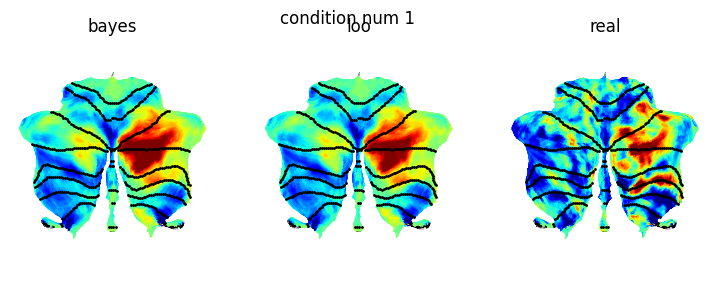

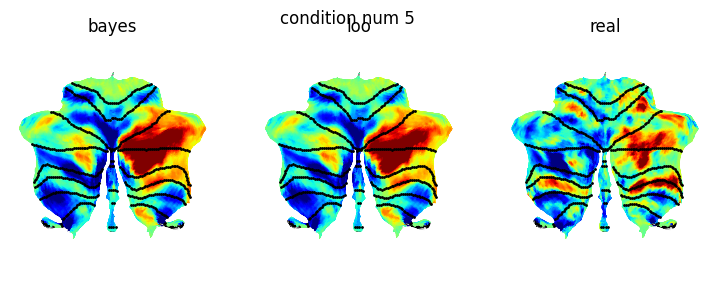

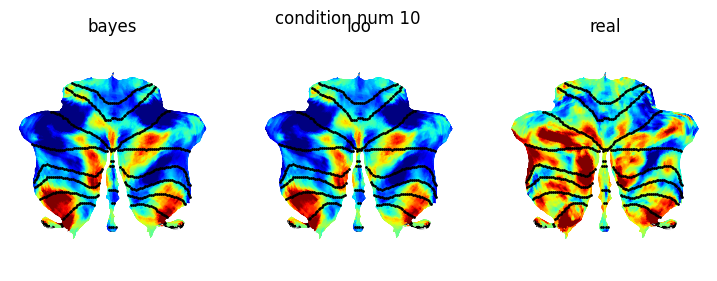

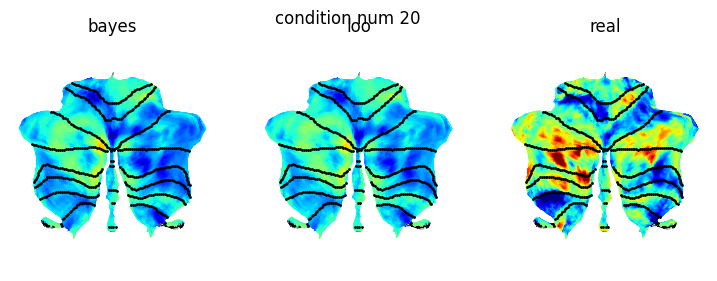

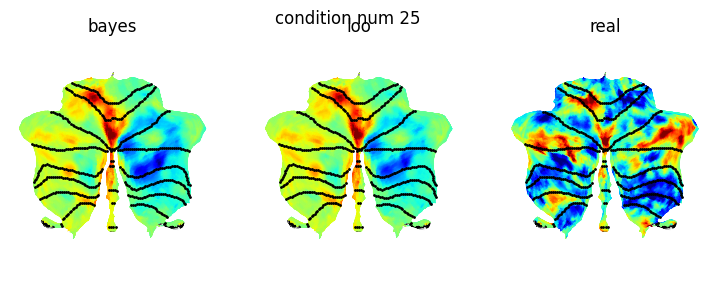

In [14]:
cereb_atlas,_ = at.get_atlas('MNISymC3')
task_i = [1, 5, 10, 20, 25]
for i in task_i:
    plt.figure(figsize=(9,3))
    plt.suptitle(f'condition num {i}')
    plt.subplot(1,3,1)
    plot_cereb_data(Y_pred_bayes[i, :], cereb_atlas, cscale=[-0.3, 0.3])
    plt.title('bayes')
    plt.subplot(1,3,2)
    plot_cereb_data(Y_pred_loo[i, :], cereb_atlas, cscale=[-0.3, 0.3])
    plt.title('loo')
    plt.subplot(1,3,3)
    plot_cereb_data(Y[i, :], cereb_atlas, cscale=[-1, 1])
    plt.title('real')
    plt.show()

In [12]:
print(f'bayes-loo model corr coef: {np.corrcoef(fitted_model_bayes[0][3].coef_.flatten(), fitted_model_loo[0][3].coef_.flatten())[0,1]:.4f}')
print(f'bayes-loo prediction corr coef: {np.corrcoef(Y_pred_bayes.flatten(), Y_pred_loo.flatten())[0,1]:.4f}')
print(f'bayes prediction and Y corr coef: {np.corrcoef(Y_pred_bayes.flatten(), Y.flatten())[0,1]:.4f}')

bayes-loo model corr coef: 0.9899
bayes-loo prediction corr coef: 0.9964
bayes prediction and Y corr coef: 0.4822


In [14]:
print(f'bayes-loo model cov: {np.cov(fitted_model_bayes[0][3].coef_.flatten(), fitted_model_loo[0][3].coef_.flatten())[0,1]:.4f}')
print(f'bayes-loo prediction cov: {np.cov(Y_pred_bayes.flatten(), Y_pred_loo.flatten())[0,1]:.4f}')
print(f'bayes prediction and Y cov: {np.cov(Y_pred_bayes.flatten(), Y.flatten())[0,1]:.4f}')

bayes-loo model cov: 0.0000
bayes-loo prediction cov: 0.0287
bayes prediction and Y cov: 0.0840


In [15]:
print(f'bayes coef norm: {np.linalg.norm(fitted_model_bayes[0][3].coef_):.4f}')
print(f'loo coef norm: {np.linalg.norm(fitted_model_loo[0][3].coef_):.4f}')
print(f'difference coef norm: {np.linalg.norm(fitted_model_bayes[0][3].coef_ - fitted_model_loo[0][3].coef_):.4f}')

bayes coef norm: 1.4595
loo coef norm: 1.4000
difference coef norm: 0.2113


In [16]:
cond_num = 1
print(f'bayes pred norm: {np.linalg.norm(Y_pred_bayes[cond_num, :]):.4f}')
print(f'loo pred norm: {np.linalg.norm(Y_pred_loo[cond_num,:]):.4f}')
print(f'difference pred norm: {np.linalg.norm(Y_pred_bayes[cond_num, :] - Y_pred_loo[cond_num,:]):.4f}')

bayes pred norm: 11.2571
loo pred norm: 10.5757
difference pred norm: 1.2762


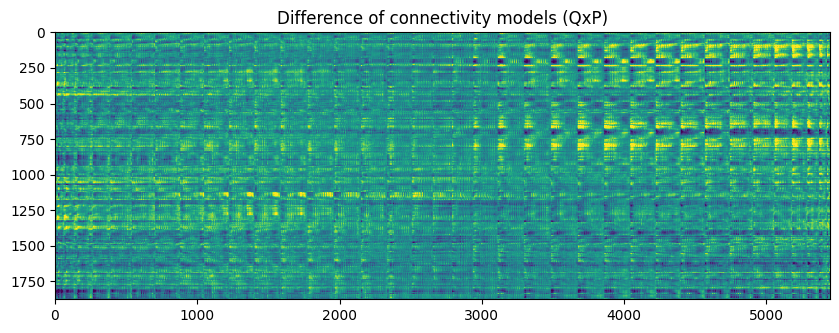

In [17]:
plt.subplots(figsize=(10,7))
plt.imshow(fitted_model_bayes[0][3].coef_.T - fitted_model_loo[0][3].coef_.T)
plt.title('Difference of connectivity models (QxP)')
plt.clim([-0.0001, 0.0001])

Text(0.5, 1.0, 'loo average connectivity weights')

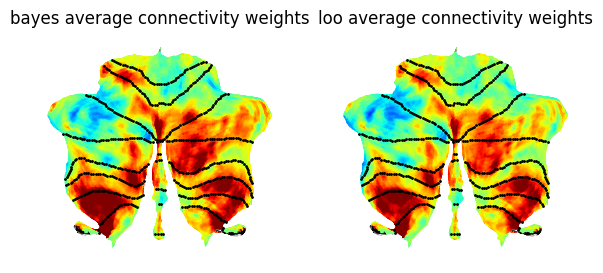

In [18]:
cereb_atlas,_ = at.get_atlas('MNISymC3')
task_i = [1, 5, 10, 20, 25]
plt.subplots(1,2,figsize=(7,3))
plt.subplot(1,2,1)
plot_cereb_data(np.nanmean(fitted_model_bayes[0][3].coef_.T, axis=0), cereb_atlas, cscale=[-0.0001, 0.0001])
plt.title('bayes average connectivity weights')
plt.subplot(1,2,2)
plot_cereb_data(np.nanmean(fitted_model_loo[0][3].coef_.T, axis=0), cereb_atlas, cscale=[-0.0001, 0.0001])
plt.title('loo average connectivity weights')